# VistaMilk data challenge

#### Adaptation on Antonio's code

## Data description
Data used in this study originated from Teagasc Moorepark Dairy Research Farm (Fermoy, Co. Cork, Ireland) between May and August in 2015, 2016, and 2017. A total of 120 HolsteinFriesian cows from different parities were involved in the experiment across the years, with a mean number of 36 samples per cow, and with some of the cows participating in the experiment in more than 1 yr. Each year, 54 cows were randomly assigned to different dietary treatments for the entire lactation period. The treatment diets included grass (GRS), which consisted of cows maintained outdoors on a perennial ryegrass sward only, clover (CLV), where cows were maintained outdoors on a perennial ryegrass white clover sward (with an annual average clover content of 20%) only, and TMR, where cows were maintained indoors and fed with a single nutritional mix containing grass silage, maize silage, and concentrates. Further information on the experimental design and dietary treatments have been described by O’Callaghan et al. (2016). The cows were milked twice daily (0730 and 1530 h), and a.m. and p.m. milk samples were collected once weekly from consecutive milkings and analysed by a Pro-Foss FT6000 (FOSS). A total of 4,364 milk spectra were stored, comprising 1,060 wavelengths in the region from 925 cm−1 and 5,010 cm−1. The wavelengths values were recorded as transmittance values.

## tl;dr
This is a classification problem where 3 classes are targeted:

- GRS
- CLV
- TMR

Data are sampled from 54 cows across 3 years. Each data points contain 1060 wavelengths within a specified light region.

In [1]:
import sys
import importlib

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from src import utils

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from PIL import Image

importlib.reload(utils)

<module 'src.utils' from '../src/utils.py'>

In [2]:
# read data in
# make the conversion only one as the xlsx files take forever to load
full_data = Path('..', 'data', 'full_dataset.xlsx')
train_path = Path('..', 'data', 'raw_train.csv')
test_path = Path('..', 'data', 'raw_test.csv')

train_df = utils.read_raw_data(full_data, train_path, 0)
test_df = utils.read_raw_data(full_data, test_path, 1)

In [3]:
# Fixing the dataset

train_df.drop(train_df[train_df.col1<1].index.tolist(), axis=0, inplace=True)
test_df.drop(test_df[test_df.col1<1].index.tolist(), axis=0, inplace=True)


train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

In [4]:
no_samples = train_df.shape[0]
no_features = train_df.shape[1] - 1

print(f'Total samples: {no_samples}')
print(f'Total features: {no_features}')

Total samples: 3244
Total features: 1060


In [5]:
# np.median(clv.values, axis=0)

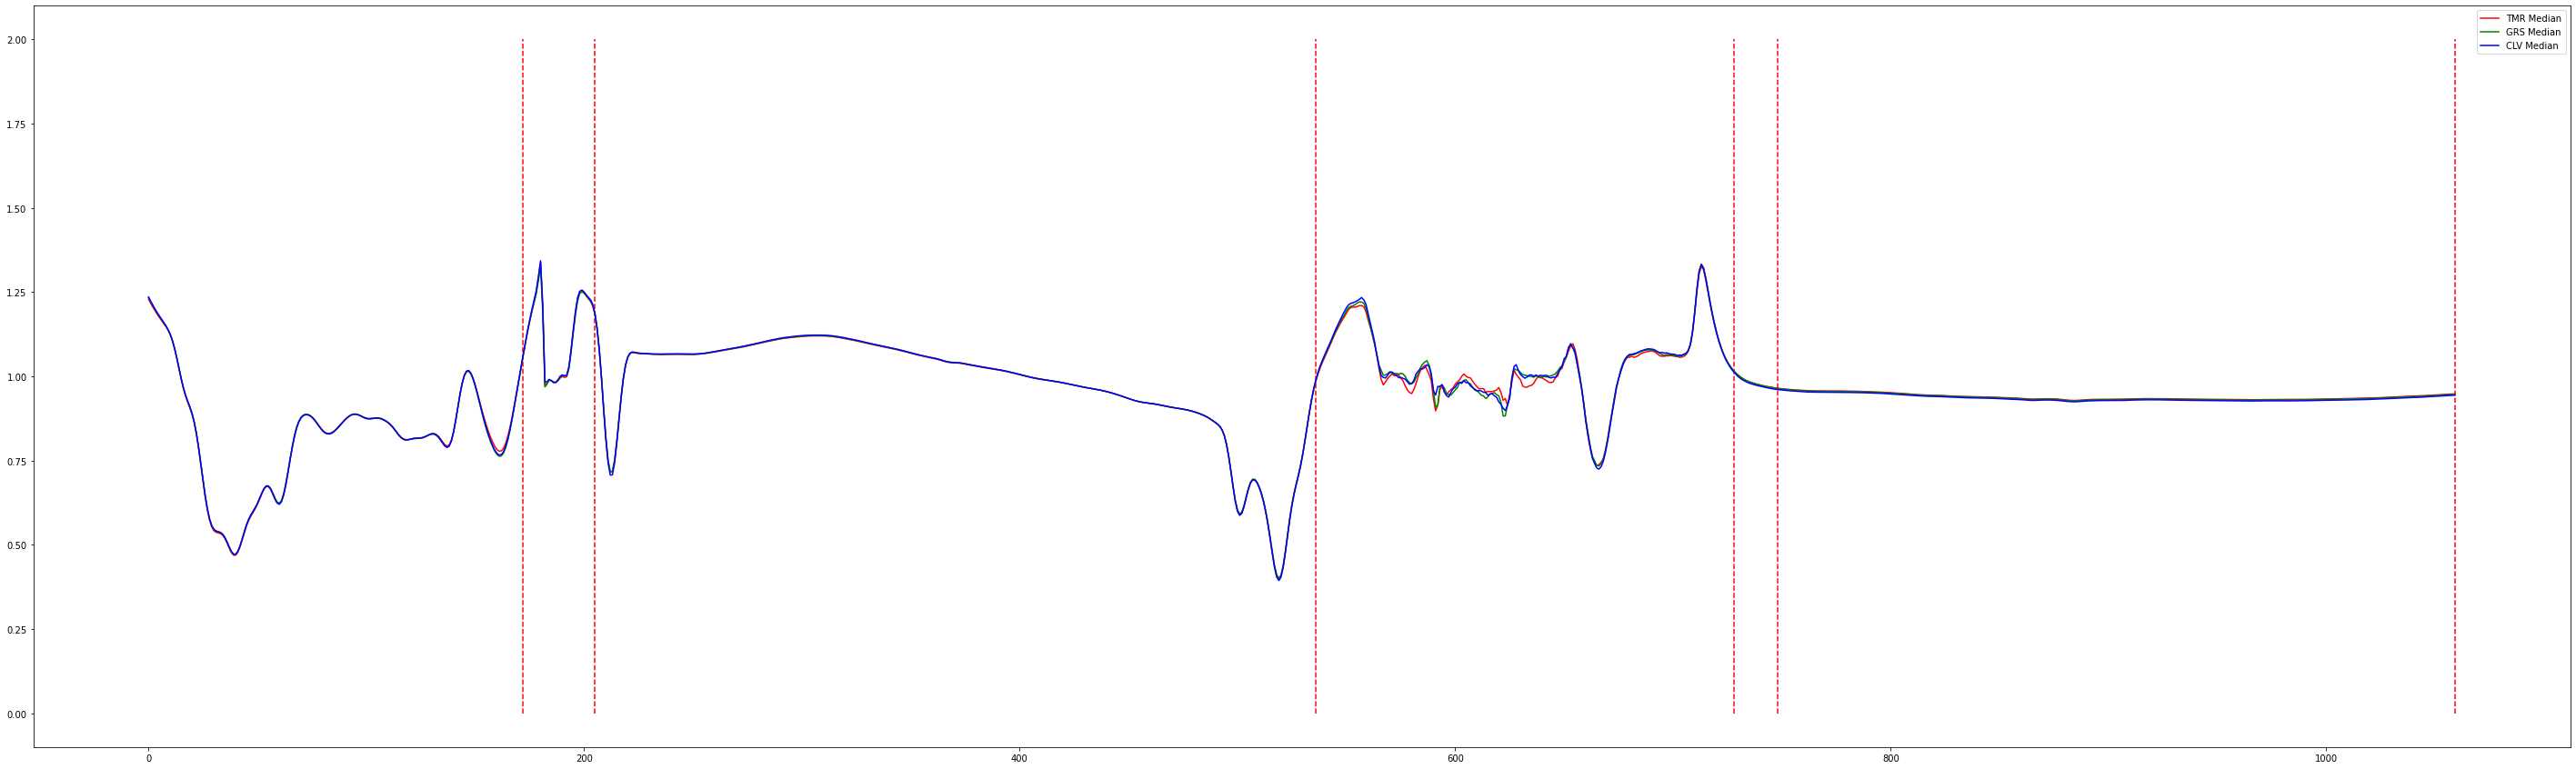

In [6]:
clv = train_df[train_df['Diet'] == 'CLV'].drop(['Diet'], axis=1)
grs = train_df[train_df['Diet'] == 'GRS'].drop(['Diet'], axis=1)
tmr = train_df[train_df['Diet'] == 'TMR'].drop(['Diet'], axis=1)


# grs = train_df[train_df['Diet'] == 'GRS'].drop(['Diet'], axis=1)
# grs_centroid = np.mean(grs.values, axis=0)

# tmr = train_df[train_df['Diet'] == 'TMR'].drop(['Diet'], axis=1)
# tmr_centroid = np.mean(grs.values, axis=0)

fig = plt.figure(figsize=(50, 15))



# plt.errorbar(x=range(len(np.mean(clv.values, axis=0))),y=np.mean(clv.values, axis=0),
#              xerr=0,yerr=1*np.std(grs.values, axis=0)/2,fmt='|',ecolor='yellow', label='CLV')

# plt.errorbar(x=range(len(np.mean(grs.values, axis=0))),y=np.mean(grs.values, axis=0),
#              xerr=0,yerr=1*np.std(grs.values, axis=0)/2,fmt='|',ecolor='orange', label='GRS')

# plt.errorbar(x=range(len(np.mean(tmr.values, axis=0))),y=np.mean(tmr.values, axis=0),
#              xerr=0,yerr=1*np.std(tmr.values, axis=0),fmt='|',ecolor='yellow', label='TMR')



plt.plot(np.median(tmr.values, axis=0), label='TMR Median', color='red')


plt.plot(np.median(grs.values, axis=0), label='GRS Median', color='green')



plt.plot(np.median(clv.values, axis=0), label='CLV Median', color='blue')
plt.vlines(172, ymin=0, ymax=2, color='red', linestyle='--')
plt.vlines(205, ymin=0, ymax=2, color='red', linestyle='--')

plt.vlines(536, ymin=0, ymax=2, color='red', linestyle='--')
plt.vlines(728, ymin=0, ymax=2, color='red', linestyle='--')

plt.vlines(748, ymin=0, ymax=2, color='red', linestyle='--')
plt.vlines(1059, ymin=0, ymax=2, color='red', linestyle='--')
#plt.plot(clv_std, label='std')
#plt.plot(clv_std2, label='std')
#plt.plot(tmr_centroid, label='TMR centroid')

# plt.grid()
plt.legend()
plt.show()

## Target variable: `Diet` column

In [7]:
target = train_df['Diet']
unique_target_values = target.unique()
target_stats = {}

for target_value in unique_target_values:
    target_stats[target_value] = {
        'count': train_df[train_df['Diet'] == target_value].shape[0],
        'perc': train_df[train_df['Diet'] == target_value].shape[0] / train_df.shape[0]
    }

print(f'Unique values in the target column: {unique_target_values}')
print()

for t, v in target_stats.items():
    count = v['count']
    perc = v['perc']
    print(f'Target {t}: {count} instances ({perc}% of total)')

Unique values in the target column: ['GRS' 'CLV' 'TMR']

Target GRS: 1082 instances (0.33353884093711467% of total)
Target CLV: 1108 instances (0.34155363748458695% of total)
Target TMR: 1054 instances (0.3249075215782984% of total)


## Basic model training
These training examples are based on a stratified 5-fold cross validation.

In [8]:
# data shuffling here: move somewhere else
train_df = train_df.sample(frac=1)

X_train = train_df.drop(['Diet'], axis=1)
y = train_df['Diet']

In [9]:
from sklearn.linear_model import LogisticRegressionCV


In [10]:
def tab_performance(X_train, y):
    classifiers = {
#         'knn': KNeighborsClassifier(),
#         'ridge': RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)), # 0.740
        'LogReg': LogisticRegressionCV(Cs=10, solver='sag',max_iter=1000), # avg. 0.46
        
#         'tree': DecisionTreeClassifier(),
#         'forest': RandomForestClassifier(), # avg. 0.52
#         'SVM': SVC(),
#         'adaboost': AdaBoostClassifier(),
#         'mlp': MLPClassifier()
    }

    for cls_name, classifier in classifiers.items():
        score, pred, report, confusion = utils.basics(classifier, X_train, y)

    #     print(f'[bold underline magenta]{cls_name}[/bold underline magenta]')
        print(f'{cls_name} Scores: {score} (avg. {score.mean()})')
        print(report)
        print(confusion)
        print("--"*20)

In [11]:
# tab_performance(X_train, y)

In [12]:
from sktime.classification.dictionary_based import IndividualBOSS, BOSSEnsemble
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier,ProximityForest
from sktime.utils.data_processing import from_2d_array_to_nested
from sktime.classification.kernel_based import Arsenal
from sktime.transformations.panel.rocket import Rocket
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.catch22 import Catch22

In [13]:
def convert_to_ts(df):
    
    return from_2d_array_to_nested(df)
    

In [14]:
def temporal_performance(X_train, y):
    
    X_train = convert_to_ts(X_train)
    
    
    classifiers = {
#         'Boss': IndividualBOSS(),
#         'BossEnsemble': BOSSEnsemble(max_ensemble_size=5),
#         'dtw': KNeighborsTimeSeriesClassifier(),
#         'PF': ProximityForest(),
#         'Arsenal': Arsenal(),
#         'Rocket': make_pipeline(Rocket(), RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)), # 0.46
#         'c22': make_pipeline(Catch22(), RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)), #0.37 
    }

    for cls_name, classifier in classifiers.items():
        score, pred, report, confusion = utils.basics(classifier, X_train, y)

    #     print(f'[bold underline magenta]{cls_name}[/bold underline magenta]')
        print(f'{cls_name} Scores: {score} (avg. {score.mean()})')
        print(report)
        print(confusion)
        print("--"*20)

In [15]:
# temporal_performance(X_train, y)

In [18]:
#X_train.head()

In [21]:
target_distrib = pd.DataFrame({
    'count': y.value_counts(),
    'share': y.value_counts() / y.shape[0] * 100
})

target_distrib.sort_index()

,count,share
CLV,1108,34.155364
GRS,1082,33.353884
TMR,1054,32.490752


In [24]:
import seaborn as sns

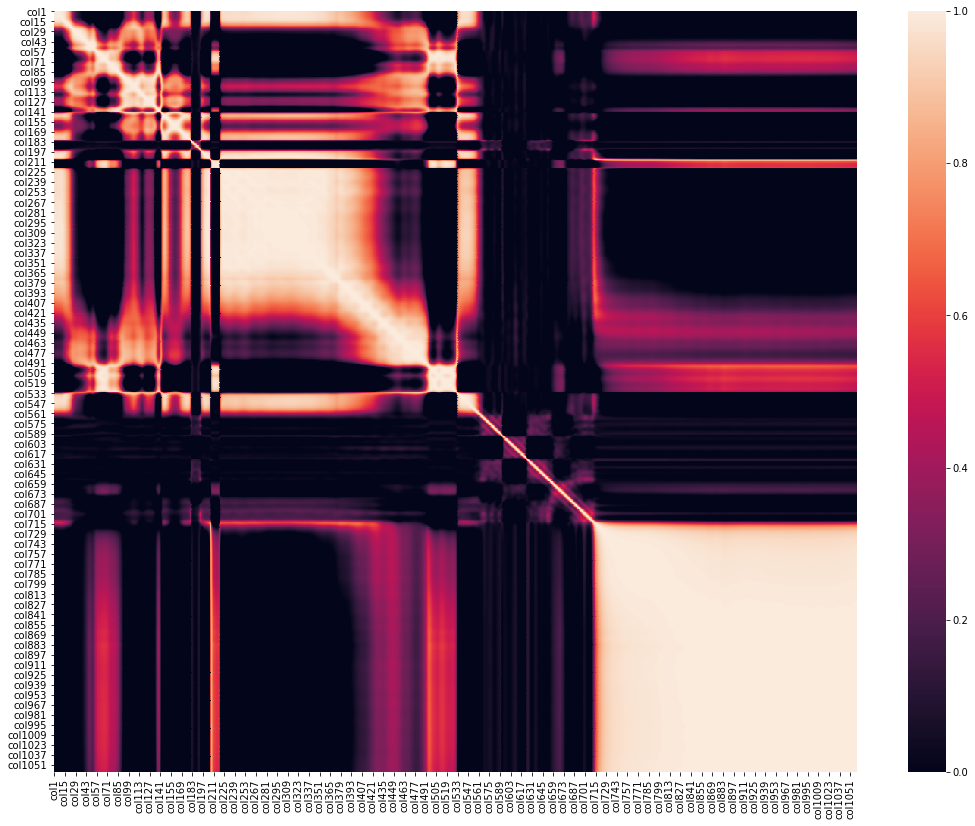

In [25]:
plt.figure(figsize=(18, 14))
correlation = X_train.corr()
sns.heatmap(
    correlation, 
    vmin=0
)
plt.show()

In [26]:
# High-correlated feature pairs w/o auto-correlations
threshold = 0.8
correlation = X_train.corr()

corr_pairs = (
    correlation[abs(correlation) > threshold][correlation != 1.0]
).unstack().dropna().to_dict()

unique_corr_pairs = pd.DataFrame(
    list(
        set([(tuple(sorted(key)), corr_pairs[key]) for key in corr_pairs])
    ), columns=['pair', 'corr']
)

unique_corr_pairs

,pair,corr
0,"(col1, col240)",0.964763
1,"(col2, col377)",0.885873
2,"(col1012, col947)",0.999391
3,"(col278, col522)",-0.949781
4,"(col237, col518)",-0.923814
...,...,...
110902,"(col40, col43)",0.988767
110903,"(col805, col925)",0.991974
110904,"(col328, col523)",-0.953685
110905,"(col750, col973)",0.969579


In [29]:
print('Train data samples (w/ duplicates): \t', X_train.shape[0])
df_train_dedup = pd.DataFrame(
    [list(tup) for tup in X_train.value_counts().index.values], 
    columns=X_train.columns
)

print('Train data samples (w/o duplicates): \t', df_train_dedup.shape[0])

Train data samples (w/ duplicates): 	 3244
Train data samples (w/o duplicates): 	 3244


In [38]:
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

SEED = 42
N_SPLITS = 10

folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

In [39]:
# !pip install tqdm

In [41]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
X=X_train

y_pred, y_prob, scores = [], [], []

for fold, (train_id, valid_id) in enumerate(tqdm(folds.split(X, y), total=N_SPLITS)):
    
    # Splitting (w/ sample weights)
    X_train, y_train, sample_weight_train = X.iloc[train_id], y.iloc[train_id], sample_weight.iloc[train_id]
    X_valid, y_valid, sample_weight_valid = X.iloc[valid_id], y.iloc[valid_id], sample_weight.iloc[valid_id]
    
    # Model with params
    params = {
        'n_estimators': 300,
    }
    
    model = ExtraTreesClassifier(
        **params,
        n_jobs=-1,
        random_state=SEED
    )

    # Training (w/ sample weights)
    model.fit(X_train, y_train, sample_weight_train)
    
    # Evaluation
    valid_pred = model.predict(X_valid)
    valid_score = accuracy_score(y_valid, valid_pred, sample_weight=sample_weight_valid)
    
    print(f'### \033[1;31;43m Fold: {fold} \033[0;0m')
    print(f'Accuracy score: {valid_score:6f} \n')
    
    scores.append(valid_score)
    
    # Prediction for submission
    y_pred.append(model.predict(df_test))
    y_prob.append(model.predict_proba(df_test))

  0%|          | 0/10 [00:00<?, ?it/s]


NameError: name 'sample_weight' is not defined